## Mitigating a backdoor attack

In this notebook, we use Coar attributions in order to improve a model's robustness to backdoor attacks.
Specifically, given a CIFAR-10 ResNet model, we apply Coar-Edit to identify components that, when ablated, signficantly mitigates the effect of a backdoor attack on model predictions. This experiment reproduces our findings in Section 5.4 of our paper.

In [7]:
import os 
import sys 
sys.path.append('..')

import functools 
import torch
import numpy as np
import pandas as pd 
from torch import nn
import seaborn as sns
import tqdm

from src.models import cifar_resnet
from src.utils import ndm_utils
from src.utils import data_utils
from src.utils import eval_utils
from src.data import ffcv_pipelines
import coar_edit

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Download models, attributions, and dataloaders

In [8]:
print ('Downloading dataloaders (FFCV format)')
!wget -q -nc 'https://www.dropbox.com/scl/fi/4zj04xkgnb5mpw4aosvrt/cifar10.beton?rlkey=wspv74qs0h7l5cbxmzntmsywe&dl=0' -O out/cifar.beton
!wget -q -nc 'https://www.dropbox.com/scl/fi/s82vj7jwn2lsrq3z16jis/backdoored_cifar_test.pt.beton?rlkey=jqqxgpdfjw249ahgyu6us030l&dl=0' -O out/backdoored_cifar.beton

print ('Downloading models')
!wget -q -nc 'https://www.dropbox.com/scl/fi/58a7isuud54g1nwiawypu/backdoored_cifar.pt?rlkey=whucsf2rr4b6eo7fg5gzxzmla&dl=0' -O out/backdoored_cifar_model.pt

print ('Downloading attributions')
!wget -q -nc 'https://www.dropbox.com/scl/fi/i8pqcpwgx5t3twry7s6jm/backdoored_cifar_without.pt?rlkey=yggr7qxuqjsljybrwcy1d2nns&dl=0' -O out/backdoor_without_attb.pt
!wget -q -nc 'https://www.dropbox.com/scl/fi/t86q0v4hjsjhrpztge7tt/backdoored_cifar_with.pt?rlkey=0maqv1e01jjpy5zm6q5jkbbdx&dl=0' -O out/backdoor_with_attb.pt 

list(os.listdir('out/'))

['waterbirds_model.pt',
 'backdoored_cifar_model.pt',
 'cifar.beton',
 'backdoor_without_attb.pt',
 'waterbirds_train_attb.pt',
 'waterbirds_train.beton',
 'backdoor_with_attb.pt',
 'waterbirds_test.beton',
 'backdoored_cifar.beton']

### Setup

In [9]:
DEVICE = torch.device(0) 

def get_model():
    model = torch.load('out/backdoored_cifar_model.pt').cpu().eval()
    return model

def get_attributions():
    attbs = {
        'with_backdoor': 'out/backdoor_with_attb.pt',
        'without_backdoor': 'out/backdoor_without_attb.pt'
    }
    
    return {k: torch.load(v)['weight'].T.float() for k, v in attbs.items()}

def get_loaders(batch_size=256, num_workers=2):
    pipeline = ffcv_pipelines.get_pipelines('cifar10', 'test', DEVICE)

    loaders = {
        'with_backdoor': 'out/backdoored_cifar.beton',
        'without_backdoor': 'out/cifar.beton'
    }
    
    return {k: data_utils.get_ffcv_loader(v, batch_size, num_workers, pipeline, is_train=False)
            for k, v in loaders.items()}

def get_model_components(model):
    def is_component(comp_name):
        valid = 'conv' in comp_name
        return valid

    def get_comp_dim(comp):
        assert type(comp) is nn.Conv2d
        return comp.out_channels

    comp_dims = {}
    for comp_name, comp in model.named_modules():
        if not is_component(comp_name): continue
        key = comp_name+'.weight'
        comp_dims[key] = get_comp_dim(comp)

    return comp_dims

In [10]:
# get model, data, attributions 
model = get_model()
comps = get_model_components(model)
num_components = sum(comps.values())

attb_map = get_attributions()
loader_map = get_loaders() 
editor = coar_edit.CoarEdit()

In [11]:
# evaluate model accuracy 
model = model.to(DEVICE)
for k, dl in loader_map.items():
    acc = eval_utils.get_accuracy_and_loss(model, dl, DEVICE, use_tqdm=False)['acc']
    print ('{}: {:.2f}'.format(k, acc))

with_backdoor: 0.37
without_backdoor: 0.89


### Apply Coar-Edit

In [12]:
# prepare inputs 
num_samples = 10 # number of paired attributions to sample
subset_size = 30 # number of components to ablate 
ablate_order = 'bottomk' # get components with most negative scores (to increase margin)

# sample random paired example-level attributions for Coar-Edit
if ablate_order=='topk':
    # "airplane" class examples iff ablate_order is topk bc trigger is correlated with airplane class 
    valid_inds = (eval_utils.get_labels(loader_map['without_backdoor'])==0).nonzero()[0]
else: 
    valid_inds = (eval_utils.get_labels(loader_map['without_backdoor'])!=0).nonzero()[0]
    
sample_inds = np.random.choice(valid_inds, size=num_samples, replace=False)
sampled_attb_map = {k: v[sample_inds] for k, v in attb_map.items()}

for k, v in sampled_attb_map.items():
    print (k, v.shape)

with_backdoor torch.Size([10, 2304])
without_backdoor torch.Size([10, 2304])


In [13]:
# use Coar-Edit to identify a subset of components to ablate 
scores = editor.score_components(sampled_attb_map['with_backdoor'],
                                 sampled_attb_map['without_backdoor'])

subset = editor.get_subset(scores, subset_size, ablate_order)
subset_inds = subset.indices.numpy()
ablate_set = [ndm_utils.get_component_from_index(ind, comps) for ind in subset_inds]
ablate_set[:10]

[('conv1.weight', 247),
 ('layer.1.conv1.weight', 99),
 ('layer.1.conv2.weight', 134),
 ('layer.0.conv1.weight', 226),
 ('layer.2.conv1.weight', 37),
 ('conv1.weight', 183),
 ('layer.1.conv1.weight', 35),
 ('conv1.weight', 94),
 ('layer.1.conv1.weight', 179),
 ('conv1.weight', 95)]

100%|█████████████████████████████████████████████████████████████████████| 31/31 [00:23<00:00,  1.34it/s]


,Number of components ablated,Data split,Accuracy
0,0,Test accuracy (without backdoor),0.8886
1,2,Test accuracy (without backdoor),0.8874
2,4,Test accuracy (without backdoor),0.8871
3,6,Test accuracy (without backdoor),0.8857
4,8,Test accuracy (without backdoor),0.8837


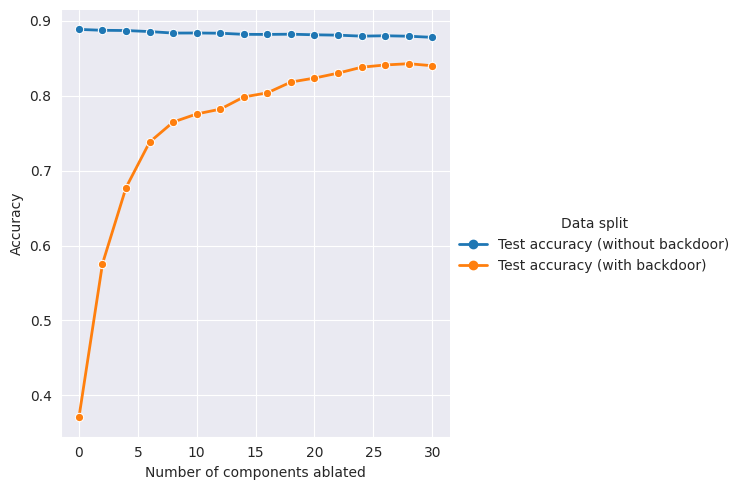

In [14]:
# iteratively ablate identified components and evaluate model performance 
masked_model = get_model()
rows = [] 
eval_every = 2

for k in tqdm.trange(0, len(subset_inds)+1):
    # ablate
    masked_model = editor.ablate_model_given_indices(masked_model.cpu(), comps, subset_inds[:k])
    masked_model = masked_model.to(DEVICE)
    
    if k % eval_every != 0: 
        continue 
    
    # eval
    acc_row = {k: eval_utils.get_accuracy_and_loss(masked_model, dl, DEVICE, use_tqdm=False)['acc']
               for k, dl in loader_map.items()}
    
    # log
    acc_row['Number of components ablated'] = k     
    acc_row['Test accuracy (without backdoor)'] = acc_row.pop('without_backdoor')
    acc_row['Test accuracy (with backdoor)'] = acc_row.pop('with_backdoor')
    
    rows.append(acc_row)
    
df = pd.DataFrame(rows).melt(id_vars=['Number of components ablated'], 
                             value_vars=['Test accuracy (without backdoor)',
                                        'Test accuracy (with backdoor)'],
                             var_name='Data split', 
                             value_name='Accuracy')

# plot effect of edit on model performance 
sns.set_style('darkgrid')
sns.relplot(data=df, 
            x='Number of components ablated', 
            y='Accuracy', 
            hue='Data split',
            kind='line', 
            lw=2, marker='o')

df.head(5)